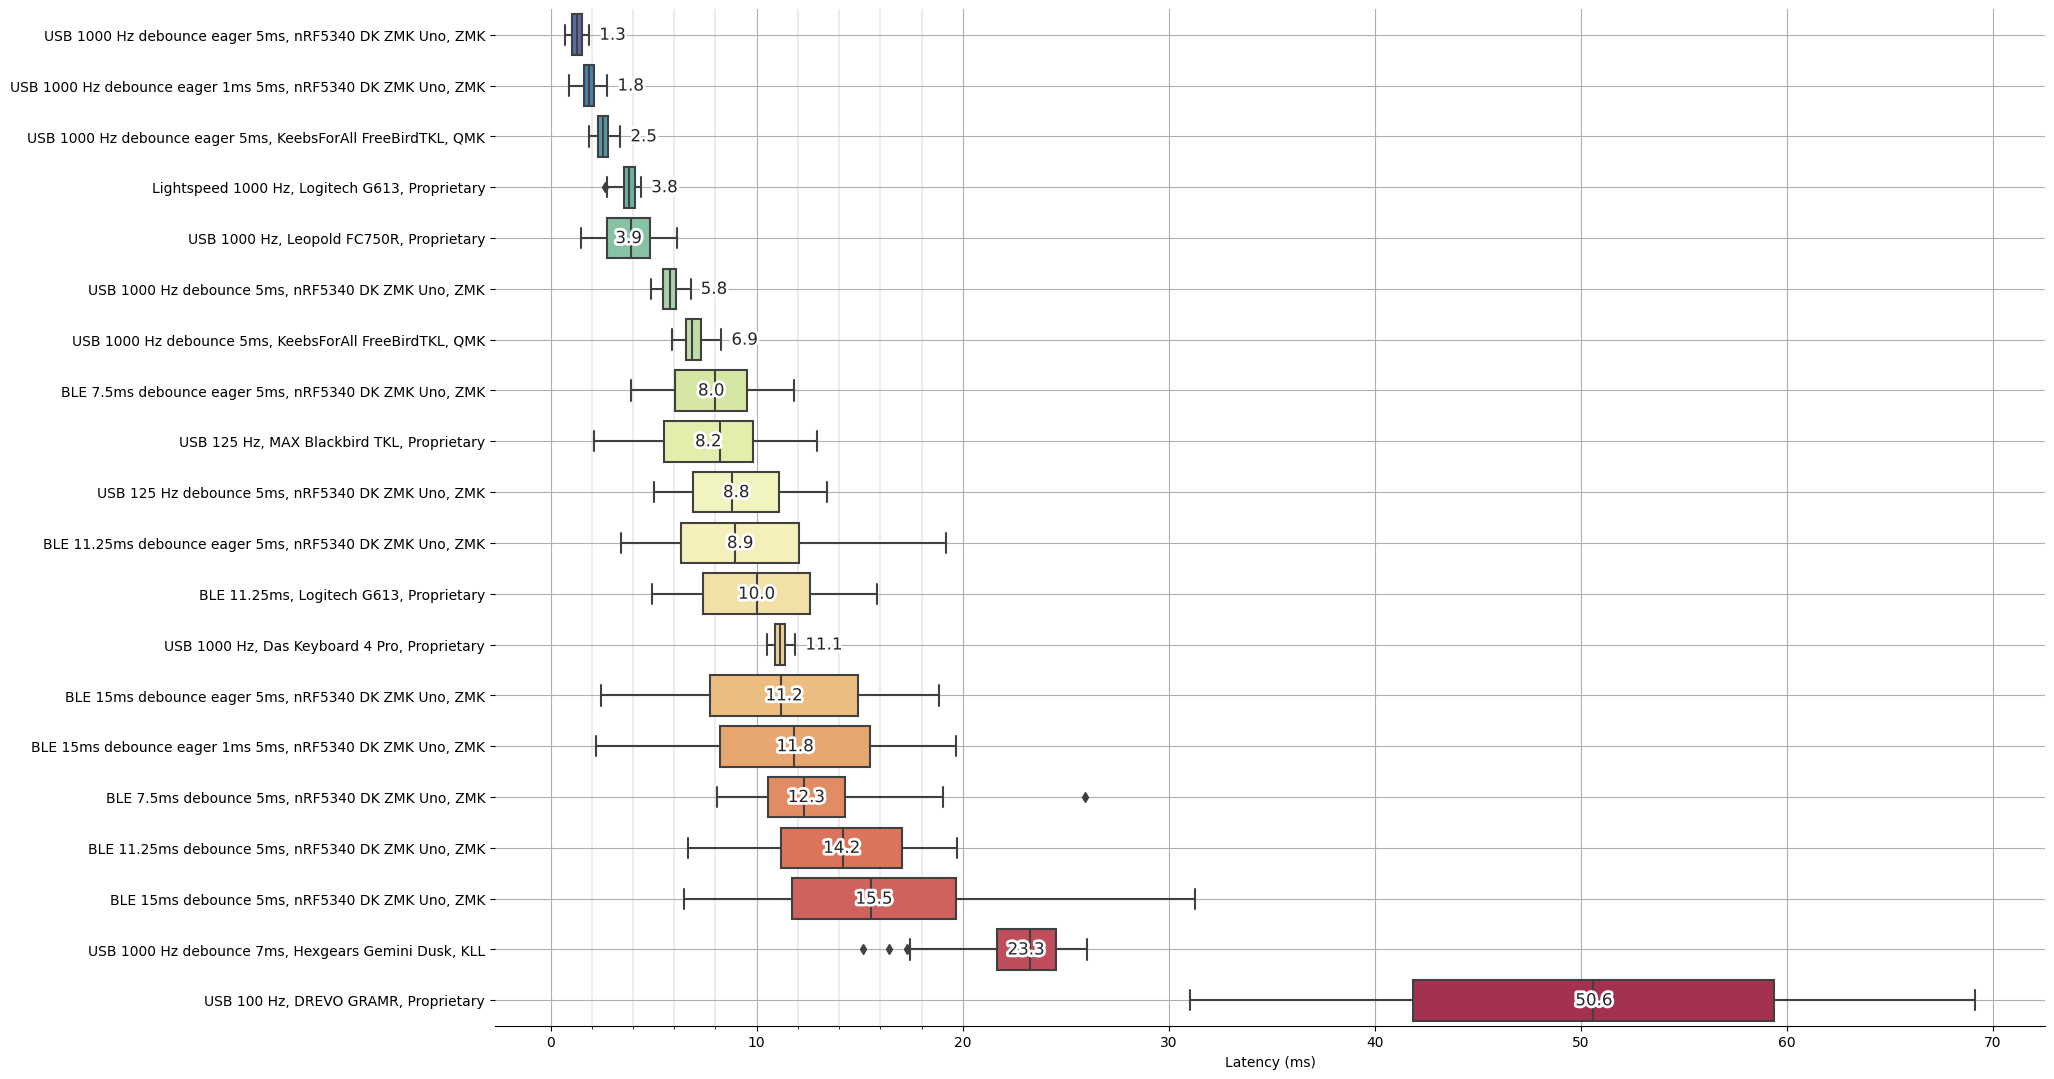

In [1]:
# Full chart
# %load_ext autoreload
# %autoreload 2


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from chart import get_data, add_median_text, clear_text


CHART_WIDTH = 20
ROW_HEIGHT = 0.66

df = get_data()
n_rows = len(df.keys())
fig, ax = plt.subplots(figsize=(CHART_WIDTH, n_rows * ROW_HEIGHT))

sns.set_theme(style="whitegrid")
sns.boxplot(ax=ax, data=df, orient="h", palette="Spectral_r")
sns.despine(left=True, right=True, top=True)

# X axis
ax.set_axisbelow(True)
ax.set_xlabel("Latency (ms)")
ax.set_xticks(range(0, 20, 2), minor=True)
ax.xaxis.grid(True)
ax.xaxis.grid(True, which="minor", linewidth=0.33)

# Y axis
ax.yaxis.grid(True)

add_median_text(fig, ax)


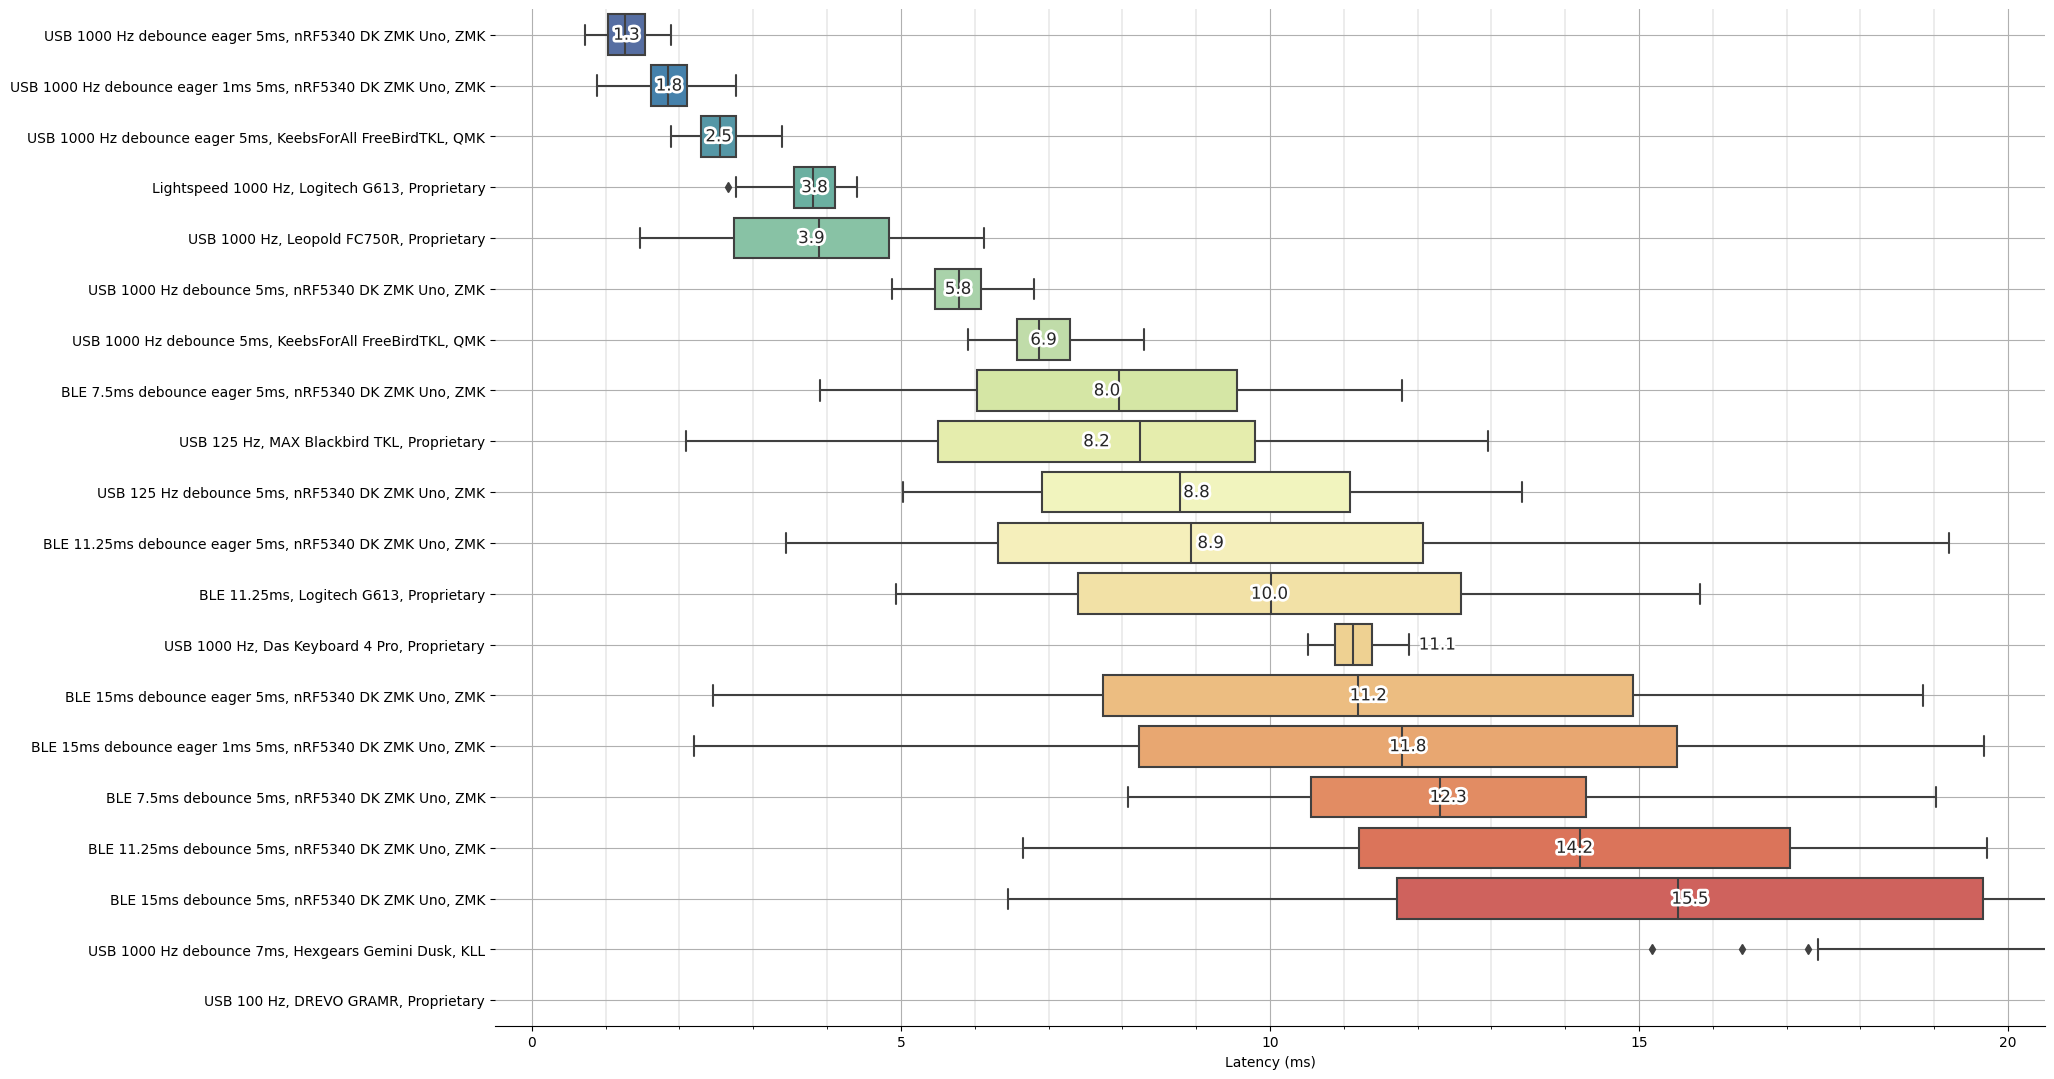

In [2]:
# Zoom chart to [0, 20] ms
ZOOM_X = 20
ax.set_xlim(-0.5, ZOOM_X + 0.5)
ax.set_xticks(range(0, ZOOM_X + 1, 5))
ax.set_xticks(range(0, ZOOM_X + 1, 1), minor=True)

clear_text(ax)
add_median_text(fig, ax)

fig
